In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from _src.pose import *
from _src.visibility import *
from _src.itor import *

In [46]:
def get_location(row):
    return [row.pose[1].location.x, row.pose[1].location.y]

def match_list(A,B):  
    '''Repeats elements in B by the length of each element in A'''
    if len(A) != len(B):
        print(f'len(A) ({len(A)}) must equal len(B) ({len(B)})')
        return
    
    b = []
    for i,a in enumerate(A):
        if len(a.shape)==1:
            a = a[np.newaxis,:]
        b.append(np.repeat(B[i],a.shape[0]))   
    return np.hstack(b)

def get_percentile(value,dist):
    return np.sum(np.array(dist)<value)/np.sum(~np.isnan(np.array(dist)))
    

In [47]:
# resfile = './_data/results/MICE_20220609_1907_DMM1_21_05_SR4_episode003.pkl'
resfile = './_data/results/MICE_20220609_1907_DMM1_21_05_SR4_episode020.pkl'
df = pd.read_pickle(resfile)
w = World.get_from_parameters_names('hexagonal','canonical','21_05')
loc = np.vstack(df.apply(get_location,axis=1))

In [48]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

def plot_frame(row, ax=plt, **kwargs):
    
    h = []
    
    # process pose data
    null_ITOR = match_list(row.null_pose,row.null_ITOR)
    null_pose = np.vstack(row.null_pose)
    true_pose = pose2array(row.pose)
    s = np.argsort(null_ITOR)
    
    # plot
    h.append(ax.scatter(null_pose[s,0],null_pose[s,1],c=null_ITOR[s],
                    edgecolors='none',vmin=0,vmax=1))
    h.append(ax.plot(true_pose[:,0],true_pose[:,1],'.',
                     markerfacecolor='w',markeredgecolor='k',
                     **kwargs))
    h.append(ax.plot(row.predator_location.x,
                     row.predator_location.y,'rx',
                     **kwargs))
    
    return h

def update_frame(i):
    
    # process pose data
    row = df.iloc[i]
    null_ITOR = match_list(row.null_pose,row.null_ITOR)
    null_pose = np.vstack(row.null_pose)
    true_pose = pose2array(row.pose)
    s = np.argsort(null_ITOR)
    
    # update plots
    H[0][0].set_offsets(np.c_[null_pose[s,0],null_pose[s,1]])
    H[0][0].set_array(np.squeeze(null_ITOR[s]))
    H[1][0].set_offsets(np.c_[null_pose[s,0],null_pose[s,1]])
    H[1][0].set_array(np.squeeze(null_ITOR[s]))
    H[0][1][0].set_xdata(true_pose[:,0])
    H[0][1][0].set_ydata(true_pose[:,1])
    H[1][1][0].set_xdata(true_pose[:,0])
    H[1][1][0].set_ydata(true_pose[:,1])
    H[0][2][0].set_xdata(row.predator_location.x)
    H[0][2][0].set_ydata(row.predator_location.y)
    H[1][2][0].set_xdata(row.predator_location.x)
    H[1][2][0].set_ydata(row.predator_location.y)
    H[2][0].set_xdata(row.frame)
    H[2][0].set_ydata(row.ITOR)
    title.set_text(f'frame {row.frame}')
    ax[0,1].set_xlim([row.pose[1].location.x - .1,
          row.pose[1].location.x + .1])
    ax[0,1].set_ylim([row.pose[1].location.y - .1,
              row.pose[1].location.y + .1])
    
    # ITOR histogram
    ax[1,1].clear()
    ax[1,1].hist(row.null_ITOR,bins=np.linspace(0,1,30),label='null')
    ax[1,1].axvline(row.ITOR,color='r',label='true')
    ax[1,1].set_ylabel('count')
    ax[1,1].set_xlabel('ITOR')
    ax[1,1].set_xlim([0,1])
    ax[1,1].set_ylim([0,500])
    ax[1,1].legend()
    ax[1,1].set_title(f'percentile = {np.round(get_percentile(row.ITOR,row.null_ITOR),3)}')

    


<IPython.core.display.Javascript object>


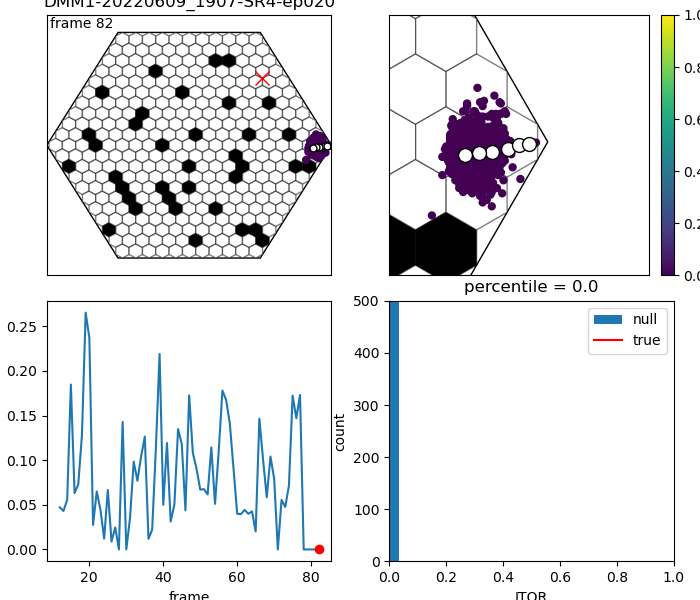

In [49]:
%matplotlib notebook
import matplotlib.animation
import matplotlib as mpl 
mpl.rcParams['animation.ffmpeg_path'] = r'C:\\ffmpeg\\bin\\ffmpeg.exe'

# setup
i = 0
row = df.iloc[i]
fig,ax = plt.subplots(2,2,figsize=(7,6))
d = Display(w,fig_size=(6,6),outline=0.2,cell_edge_color=[0,0,0,0.5],fig=fig,ax=ax[0,0])
d = Display(w,fig_size=(6,6),outline=0.2,cell_edge_color=[0,0,0,0.5],fig=fig,ax=ax[0,1])

# plot distributions
h0 = plot_frame(row,ax[0,0],markersize=10)
h1 = plot_frame(row,ax[0,1],markersize=20)
ax[0,0].set(xlim=[0,1],ylim=[0,1])
ax[0,1].set_xlim([row.pose[1].location.x - .1,
          row.pose[1].location.x + .1])
ax[0,1].set_ylim([row.pose[1].location.y - .1,
          row.pose[1].location.y + .1])
ax[0,1].set_aspect('equal')
plt.colorbar(h1[0], ax=ax[0,1], fraction=0.046, pad=0.04)
title = ax[0,0].text(0.01,.95,f'frame {row.frame}')
ax[0,0].set_title('-'.join([row.mouse,row.session,row.experiment_type,f'ep{row.episode:03d}']))

# plot ITOR
ax[1,0].plot(df.frame,df.ITOR)
h2 = ax[1,0].plot(row.frame,row.ITOR,'ro')
ax[1,0].set_xlabel('frame')
ax[1,0].set_ylabel('ITOR')

# ITOR histogram
ax[1,1].hist(row.null_ITOR,bins=np.linspace(0,1,30),label='null')
ax[1,1].axvline(row.ITOR,color='r',label='true')
ax[1,1].set_ylabel('count')
ax[1,1].set_xlabel('ITOR')
ax[1,1].set_xlim([0,1])
ax[1,1].set_ylim([0,500])
ax[1,1].legend()
ax[1,1].set_title(f'percentile = {np.round(get_percentile(row.ITOR,row.null_ITOR),3)}')

# animate
H = [h0,h1,h2] 
ani = matplotlib.animation.FuncAnimation(fig,
                                         update_frame, 
                                         frames=range(0,len(df)),
                                         interval=1/30,
                                         repeat=False,
                                         blit=True)

# save
vidfile = resfile.replace('.pkl','.mp4',1)
writervideo = matplotlib.animation.FFMpegWriter(fps=30)
ani.save(vidfile, writer=writervideo)
